<a href="https://colab.research.google.com/github/zedt123/Diffusion-Year_3/blob/main/mixture_gaussian_conditional_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tools --> Settings --> GitHub --> Access private repositories and organizations

You can change the hyperparameters and then Runtime --> Run all (or Ctrl + F9)

# Background and Derivations

This notebook can generate samples from **any** 2D mixture of Gaussians distribution, where we know the 1st of the 2 dimensions. It uses the VP-SDE (DDPM) and the exact score.

We start from $p_T=\mathcal{N}(\boldsymbol{0}, \mathbf{I})$ trying to sample $p_0=\prod_k\pi_k\mathcal{N}(\boldsymbol{\mu}_k, \mathbf{\Sigma}_k)$

At time $t$ we have (from the forward process)

$$\boldsymbol{x}_t = \sqrt{\bar{\alpha}_t}\boldsymbol{x}_0+\sqrt{1-\bar{\alpha}_t}\boldsymbol{\epsilon}_t,\quad \boldsymbol{\epsilon}_t\sim\mathcal{N}(\boldsymbol{0}, \mathbf{I})$$

which implies the following marginal distribution

$$p_t=\sum_k\pi_k\mathcal{N}(\sqrt{\bar{\alpha}_t}\boldsymbol{\mu}_k, \mathbf{Λ}_k), \quad \mathbf{Λ}_k=\bar{\alpha}_t\mathbf{\Sigma}_k+(1-\bar{\alpha}_t)\mathbf{I}$$

We can calculate the exact score of the marginal

$$
\nabla_{\boldsymbol{x}}\log p_t=\sum_kw_k\mathbf{Λ}_k^{-1}(\sqrt{\bar{\alpha}_t}\boldsymbol{\mu}_k - \boldsymbol{x}),
$$

where

$$
w_k = \frac{\pi_k\mathcal{N}(\boldsymbol{x};\sqrt{\bar{\alpha}_t}\boldsymbol{\mu}_k, \mathbf{Λ}_k)}{\sum_j\pi_j\mathcal{N}(\boldsymbol{x};\sqrt{\bar{\alpha}_t}\boldsymbol{\mu}_j, \mathbf{Λ}_j)}
$$

# Import Libraries

In [111]:
import numpy as np
import torch
from torch.distributions import Normal, MultivariateNormal
import matplotlib.pyplot as plt

# Hyperparameters

In [112]:
# Number of reverse diffusion timesteps
T = 1000

# Number of particles for SMC
P = 1000

# Mixture weights, need to sum to 1
m_weights = np.array([0.3, 0.2, 0.5])
assert np.sum(m_weights) == 1, "Mixture weights must sum to 1."

# Mean of target distribution, shape (n_mixtures, 2)
mu = np.array([[0.0, 0.0],

               [0.1, 0.3],

               [-0.2, 0.4]
])

assert mu.shape == (len(m_weights), 2), "Means must have shape (n_mixtures, 2)"

# Covariance matrix of target distribution, shape (n_mixtures, 2, 2)
cov = np.array([[[ 0.0099,  0.0037],
                  [ 0.0037,  0.0039]],

                [[ 0.0084, -0.0069],
                  [-0.0069,  0.0098]],

                [[ 0.0032,  0.0017],
                  [ 0.0017,  0.0092]]
])

assert cov.shape == (len(m_weights), 2, 2), f"Found shape {cov.shape} Covariances must have shape (n_mixtures, 2, 2)"

# Conditional information
c = torch.tensor(0.05)

# Resampling threshold (0 means never resample, 1 always resample)
threshold = 0.5

# Helper Functions

In [113]:
def resample(x, log_w, potentials):
    """
    Perform systematic (low-variance) resampling of weighted particles.
    """
    assert x.shape[0] == log_w.shape[0], "Data and weights do not match in the particle dimension"

    P = x.shape[0]
    # Obtain normalised weights
    max_log_weight = torch.max(log_w)
    weights = torch.exp(log_w - max_log_weight)  # Subtract max for numerical stability
    weights /= torch.sum(weights)

    # Compute the cumulative sum of weights
    cumulative_sum = torch.cumsum(weights, dim=0)
    cumulative_sum[-1] = 1.0

    # Generate uniformly spaced points
    points = (torch.rand(1).item() + torch.arange(P).float()) / P
    indices = torch.searchsorted(cumulative_sum, points)

    # Handle edge cases where searchsorted might return num_particles
    indices = torch.clamp(indices, max=P - 1)

    # Gather the resampled particles
    resampled_x = x[indices]
    resampled_potentials = potentials[indices]
    resampled_weights = 0

    return resampled_x, resampled_weights, resampled_potentials, indices

def calculate_log_ess(log_w):
    """
    Compute the log-ESS from a batch of log-weights.
    """
    numerator = 2 * torch.logsumexp(log_w, dim=-1, keepdim=True)
    denominator = torch.logsumexp(2 * log_w, dim=-1, keepdim=True)
    log_ess = numerator - denominator
    return log_ess

# Conditional Diffusion

In [114]:
class conditional_diffusion:
  def __init__(self, T, m_weights, mu, cov):
    self.T = T
    self.mu = mu
    self.cov = cov
    self.m_weights = m_weights

    # Diffusion schedule (similar to https://github.com/openai/guided-diffusion, linear schedule)
    scale = 1000 / T
    self.betas = torch.linspace(scale * 0.0001, scale * 0.02, T)
    self.alphas = 1 - self.betas
    self.alphas_bar = torch.cumprod(self.alphas, dim=0)
    self.sqrt_alphas_bar = torch.sqrt(self.alphas_bar)
    self.one_over_sqrt_alphas_bar = 1 / self.sqrt_alphas_bar
    self.sqrt_alphas = torch.sqrt(self.alphas)
    self.one_over_sqrt_alphas = 1 / self.sqrt_alphas
    self.sqrt_betas = torch.sqrt(self.betas)
    self.one_minus_a_bar_over_sqrt = (1 - self.alphas_bar) / self.sqrt_alphas_bar
    self.sqrt_one_minus_a_bar = torch.sqrt(1 - self.alphas_bar)

  def score(self, x, t):
    a = self.alphas_bar[t]
    lamb = a * torch.as_tensor(self.cov, device=x.device, dtype=x.dtype) \
           + (1 - a) * torch.eye(2, device=x.device)
    mu = self.sqrt_alphas_bar[t] * torch.as_tensor(self.mu,
                                                     device=x.device,
                                                     dtype=x.dtype)

    m_weights = torch.as_tensor(self.m_weights,
                            device=x.device,
                            dtype=x.dtype)

    # Calculate the pdf of each mixture, shape (P, n_mixtures)
    mvn = MultivariateNormal(mu, lamb)
    log_p = mvn.log_prob(x.unsqueeze(1)) + torch.log(m_weights)

    w = torch.softmax(log_p, dim=1) # (P, n_mixtures)

    lamb_inv = torch.linalg.inv(lamb) # (n_mixtures, 2, 2)
    diff = mu - x.unsqueeze(1) # (P, 2)
    score_k = torch.einsum('kij,bkj->bki', lamb_inv, diff)
    score = (w.unsqueeze(-1) * score_k).sum(dim=1)
    return score

  def tds(self, c=c, P=P, tau=threshold):
    """
    Twisted diffusion sampler to generate samples from the target
    distribution.
    """
    # Conditional information
    y = torch.zeros((P,2))
    y[:,0] += c

    # Mask
    M = torch.zeros((P,2))
    M[:,0] += 1

    # Tensors to save info
    samples = torch.zeros((self.T+1, P, 2))
    log_weights_tensor = torch.zeros((self.T+1, P))
    ess_list = []

    # t=T
    x_next = torch.randn((P, 2)) # sample from N(0,I)
    s = self.score(x_next, self.T-1)
    x0 = self.one_over_sqrt_alphas_bar[self.T - 1] * x_next + self.one_minus_a_bar_over_sqrt[self.T - 1] * s
    samples[T] = x_next
    #varr = (1 - self.alphas_bar[self.T-1]) / self.alphas_bar[self.T-1] * 0.01 / ((1 - self.alphas_bar[self.T-1]) / self.alphas_bar[self.T-1] + 0.01)
    #log_potential_next = Normal(torch.masked_select(x0, M.bool()), torch.sqrt(varr)).log_prob(torch.masked_select(y, M.bool()))
    log_potential_next = Normal(torch.masked_select(x0, M.bool()), self.sqrt_one_minus_a_bar[self.T-1]).log_prob(torch.masked_select(y, M.bool()))
    log_weights_tensor[self.T] = log_potential_next

    ess_threshold_tensor = torch.tensor(threshold)
    P_tensor = torch.tensor(P)

    for t in range(self.T, 0, -1):
        # Resample
        x_next = samples[t]
        log_w = log_weights_tensor[t]
        log_ess = calculate_log_ess(log_w)
        ess_list.append(log_ess.item())
        if log_ess < (torch.log(ess_threshold_tensor) - torch.log(P_tensor)):
            x_next, _, log_potential_next, _ = resample(x_next, log_w, log_potential_next)

        x_next = x_next.requires_grad_()
        s = self.score(x_next, t-1)
        x0 = self.one_over_sqrt_alphas_bar[t-1] * x_next + self.one_minus_a_bar_over_sqrt[t-1] * s
        diff = torch.masked_select(y, M.bool()) - torch.masked_select(x0, M.bool())
        varr = (1 - self.alphas_bar[t-1]) / self.alphas_bar[t-1] * 0.01 / ((1 - self.alphas_bar[t-1]) / self.alphas_bar[t-1] + 0.01)
        log_p = -0.5 * diff.pow(2).sum() / varr
        s_cond = torch.autograd.grad(log_p, x_next)[0]
        x0 = x0.detach()
        s = s.detach()
        total_score = (s + s_cond).detach()
        x_next = x_next.detach()
        x_mean = (self.one_over_sqrt_alphas[t-1] * x_next + self.betas[t-1] * self.one_over_sqrt_alphas[t-1] * total_score)
        if t > 1:
            x = x_mean + self.sqrt_betas[t-1] * torch.randn_like(x_mean)
            samples[t-1] = x
        else:
            samples[t-1] = x_mean
        # Calculate weights
        #log_potential = Normal(torch.masked_select(x0, M.bool()), torch.sqrt(varr)).log_prob(torch.masked_select(y, M.bool()))
        log_potential = Normal(torch.masked_select(x0, M.bool()), self.sqrt_one_minus_a_bar[t-1]).log_prob(torch.masked_select(y, M.bool()))
        x_unconditional = self.one_over_sqrt_alphas[t-1] * x_next + self.betas[t-1] * self.one_over_sqrt_alphas[t-1] * s
        if t>1:
            log_unconditional = Normal(x_unconditional, self.sqrt_betas[t-1]).log_prob(x).sum(1)
            log_conditional = Normal(x_mean, self.sqrt_betas[t-1]).log_prob(x).sum(1)
        else:
            log_unconditional = Normal(x_unconditional, self.sqrt_betas[t-1]).log_prob(x_mean).sum(1)
            log_conditional = Normal(x_mean, self.sqrt_betas[t-1]).log_prob(x_mean).sum(1)
        log_weights = log_unconditional + log_potential - log_potential_next - log_conditional
        log_weights_tensor[t-1] = log_weights
        log_potential_next = log_potential

    samples = samples.numpy()
    log_weights = log_weights_tensor.numpy()
    return samples, log_weights, ess_list

  def alter_proposal(self, c=c, P=P, tau=threshold):
    """
    Alternative proposal
    """
    # Conditional information
    y = torch.zeros((P,2))
    y[:,0] += c

    # Mask
    M = torch.zeros((P,2))
    M[:,0] += 1

    # Tensors to save info
    samples = torch.zeros((self.T+1, P, 2))
    log_weights_tensor = torch.zeros((self.T+1, P))
    ess_list = []

    # t=T
    x_next = torch.randn((P, 2)) # sample from N(0,I)
    s = self.score(x_next, self.T-1)
    x0 = self.one_over_sqrt_alphas_bar[self.T - 1] * x_next + self.one_minus_a_bar_over_sqrt[self.T - 1] * s
    samples[T] = x_next
    log_potential_next = Normal(torch.masked_select(self.sqrt_alphas_bar[T-1] * x_next, M.bool()),self.sqrt_one_minus_a_bar[T-1]).log_prob(torch.masked_select(y, M.bool()))
    log_weights_tensor[self.T] = log_potential_next

    ess_threshold_tensor = torch.tensor(threshold)
    P_tensor = torch.tensor(P)

    for t in range(self.T, 0, -1):
        # Resample
        x_next = samples[t]
        log_w = log_weights_tensor[t]
        log_ess = calculate_log_ess(log_w)
        ess_list.append(log_ess.item())
        if log_ess < (torch.log(ess_threshold_tensor) - torch.log(P_tensor)):
            x_next, _, log_potential_next, _ = resample(x_next, log_w, log_potential_next)

        x_next = x_next.requires_grad_()
        diff = torch.masked_select(y, M.bool()) - torch.masked_select(self.alphas_bar[t-1] * x_next, M.bool())
        varr = (1 - self.alphas_bar[t-1]) / self.alphas_bar[t-1] * 0.01 / ((1 - self.alphas_bar[t-1]) / self.alphas_bar[t-1] + 0.01)
        # varr = 1 - alphas_bar[t-1]
        log_p = -0.5 * diff.pow(2).sum() / varr
        s_cond = torch.autograd.grad(log_p, x_next)[0]
        x_next = x_next.detach()
        s = self.score(x_next, t-1)
        total_score = (s + s_cond).detach()
        x_mean = (self.one_over_sqrt_alphas[t-1] * x_next + self.betas[t-1] * self.one_over_sqrt_alphas[t-1] * total_score)
        if t > 1:
            x = x_mean + self.sqrt_betas[t-1] * torch.randn_like(x_mean)
            samples[t-1] = x
        else:
            samples[t-1] = x_mean
        # Calculate weights
        log_potential = Normal(torch.masked_select(self.alphas_bar[t-1] * x_next, M.bool()), self.sqrt_one_minus_a_bar[t-1]).log_prob(torch.masked_select(y, M.bool()))
        x_unconditional = self.one_over_sqrt_alphas[t-1] * x_next + self.betas[t-1] * self.one_over_sqrt_alphas[t-1] * s
        if t>1:
            log_unconditional = Normal(x_unconditional, self.sqrt_betas[t-1]).log_prob(x).sum(1)
            log_conditional = Normal(x_mean, self.sqrt_betas[t-1]).log_prob(x).sum(1)
        else:
            log_unconditional = Normal(x_unconditional, self.sqrt_betas[t-1]).log_prob(x_mean).sum(1)
            log_conditional = Normal(x_mean, self.sqrt_betas[t-1]).log_prob(x_mean).sum(1)
        log_weights = log_unconditional + log_potential - log_potential_next - log_conditional
        log_weights_tensor[t-1] = log_weights
        log_potential_next = log_potential

    samples = samples.numpy()
    log_weights = log_weights_tensor.numpy()
    return samples, log_weights, ess_list

  def generate_gt_samples(self, N):
    """
    Generate ground truth samples according to the target distribution.

    Parameters
    ----------
    N : int
        Number of samples to generate

    Returns
    -------
    samples : np.array, shape (N, 2)
    """
    old = 0
    samples_k = np.round(N * self.m_weights).astype(int)
    samples = np.zeros((N, 2), dtype=float)
    for k in range(self.m_weights.shape[0]):
      samples[old:old + samples_k[k]] = np.random.multivariate_normal(self.mu[k], self.cov[k], size=samples_k[k])
      old += samples_k[k]
    return samples

  def plot_samples(self, gt_samples, gen_samples, t=0):
    """
    Create 2 plots. One with the ground truth samples and one with the
    generated samples at time t.

    Parameters
    ----------
    gt_samples : np.array, shape (N, 2)
                  Ground truth samples from the target distribution
    gen_samples : np.array, shape (T, P, 2)
                  Generated samples
    t : int
        Timestep of generated samples to plot. Default is 0 which
        corresponds to the final samples.
    """

    # Calculate x and y limits for plotting purposes
    x_low = np.min(self.mu[:, 0]) - 4 * np.sqrt(np.max(self.cov[:, 0, 0]))
    x_high = np.max(self.mu[:, 0]) + 4 * np.sqrt(np.max(self.cov[:, 0, 0]))

    y_low = np.min(self.mu[:, 1]) - 4 * np.sqrt(np.max(self.cov[:, 0, 0]))
    y_high = np.max(self.mu[:, 1]) + 4 * np.sqrt(np.max(self.cov[:, 0, 0]))

    current_sqrt_alpha_bar = self.sqrt_alphas_bar[t]
    # a = self.alphas_bar[t]
    x_intermediate = gen_samples[t]

    # Appoximate vs Exact calculations (this is for unconditional samples of p_t)
    # print("Ground truth mean:\n")
    # print(np.round(current_sqrt_alpha_bar * self.mu, 3))
    # print("Estimated mean:\n")
    # print(np.round(np.mean(x_intermediate)))

    # print("Exact covariance:\n")
    # print(np.round(a * self.cov + (1 - a) * np.eye(2)))
    # print("Estimated covariance:\n")
    # print(np.round(np.cov(x_intermediate)))

    # Plotting the target and intermediate distributions
    plt.figure(figsize=(12, 6))

    # Target Distribution
    plt.subplot(1, 2, 1)
    plt.scatter(gt_samples[:,0], gt_samples[:,1],alpha=0.6, color='skyblue')
    plt.title('Target Distribution')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.xlim(x_low, x_high)
    plt.ylim(y_low, y_high)

    # Final Intermediate
    plt.subplot(1, 2, 2)
    plt.scatter(x_intermediate[:,0], x_intermediate[:,1], alpha=0.6, color='salmon')
    for k in range(self.m_weights.shape[0]):
      plt.scatter(current_sqrt_alpha_bar*self.mu[k, 0], current_sqrt_alpha_bar*self.mu[k, 1], c='skyblue')
    plt.title(f'Approximate Distribution x_{t}')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.xlim(x_low, x_high)
    plt.ylim(y_low, y_high)

    plt.tight_layout()
    plt.show()

  def plot_ess(self, ess_list):
    plt.title("ESS at each timestep")
    plt.xlabel('t')
    plt.ylabel('ESS')
    plt.plot(np.exp(ess_list))

# Run Code

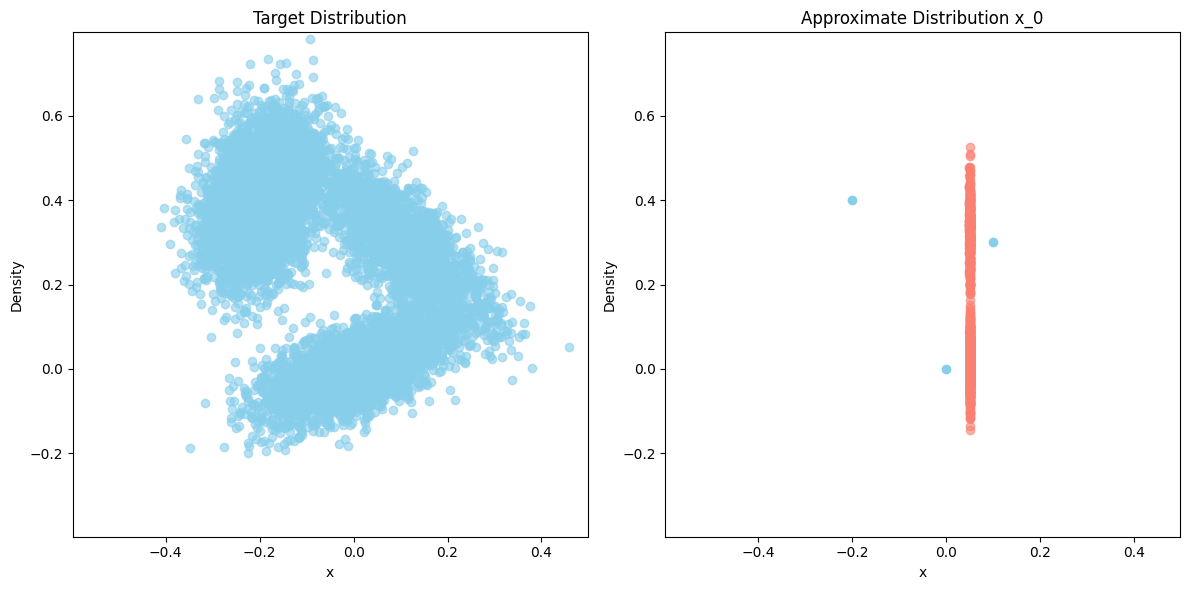

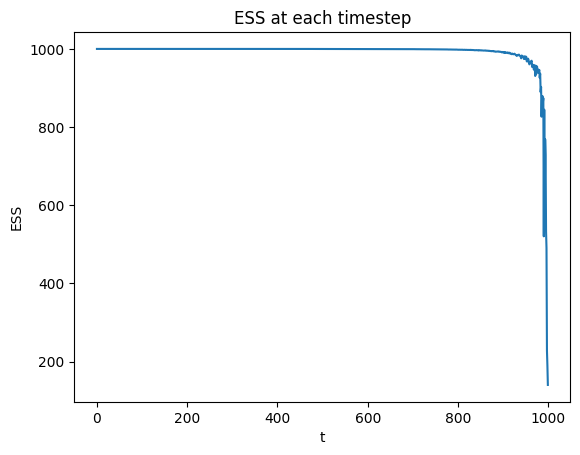

In [115]:
diffusion = conditional_diffusion(T, m_weights, mu, cov)
gt_samples = diffusion.generate_gt_samples(N=10000)
samples, log_weights, ess_list = diffusion.tds(c=c, P=P, tau=threshold)
diffusion.plot_samples(gt_samples, samples, t=0)
diffusion.plot_ess(ess_list)

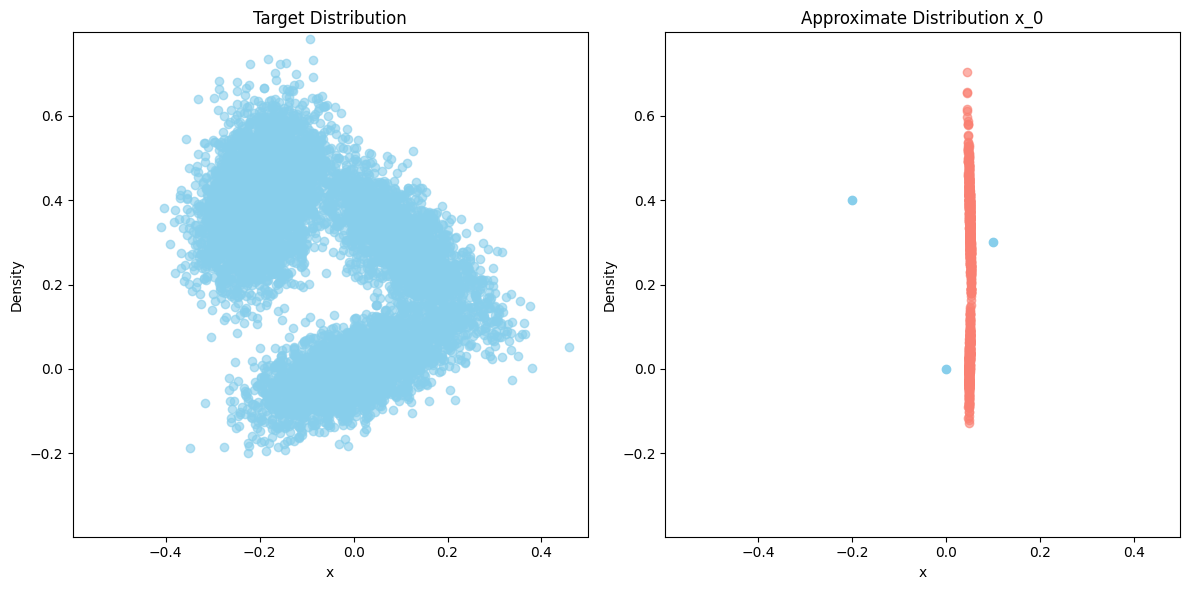

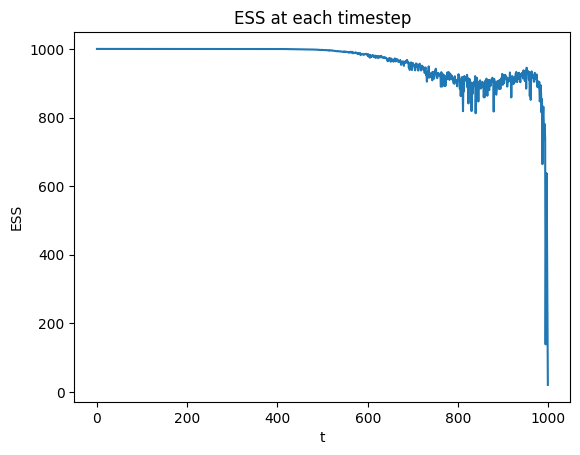

In [116]:
samples, log_weights, ess_list = diffusion.alter_proposal(c=c, P=P, tau=threshold)
diffusion.plot_samples(gt_samples, samples, t=0)
diffusion.plot_ess(ess_list)